In [1]:
import yaml
def read_yaml(yaml_file):
    with open(yaml_file, "r") as file:
        return file.readlines()  

def create_yaml(yaml_file, num_sessions):
    lines = read_yaml(yaml_file)
    
    if lines[0].startswith("# @package"):
        header = lines.pop(0)
    else:
        header = None

    data = yaml.safe_load("".join(lines))

    if "dataset" in data and "train" in data["dataset"]:
        total_sessions = data["dataset"]["train"]
        data["dataset"]["train"] = total_sessions[:num_sessions]  

    save_file = yaml_file.replace(".yaml", f"{num_sessions}.yaml")
    with open(save_file, "w") as file:
        if header:
            file.write(header)  
        yaml.dump(data, file, default_flow_style=False, sort_keys=False)

    return f"single_user{num_sessions}"

In [2]:
for i in range(1,17):
    user_file = create_yaml("config/user/single_user.yaml",i)
    !python -m emg2qwerty.train \
      user={user_file} \
      trainer.accelerator=gpu trainer.devices=1 \
      --multirun

[2025-03-07 13:25:14,753][HYDRA] Submitit 'local' sweep output dir : logs/2025-03-07/13-25-14
[2025-03-07 13:25:14,754][HYDRA] 	#0 : user=single_user1 trainer.accelerator=gpu trainer.devices=1
[2025-03-07 13:26:35,882][HYDRA] Submitit 'local' sweep output dir : logs/2025-03-07/13-26-35
[2025-03-07 13:26:35,883][HYDRA] 	#0 : user=single_user2 trainer.accelerator=gpu trainer.devices=1
[2025-03-07 13:28:34,060][HYDRA] Submitit 'local' sweep output dir : logs/2025-03-07/13-28-33
[2025-03-07 13:28:34,061][HYDRA] 	#0 : user=single_user3 trainer.accelerator=gpu trainer.devices=1
[2025-03-07 13:31:00,687][HYDRA] Submitit 'local' sweep output dir : logs/2025-03-07/13-31-00
[2025-03-07 13:31:00,688][HYDRA] 	#0 : user=single_user4 trainer.accelerator=gpu trainer.devices=1
[2025-03-07 13:33:56,892][HYDRA] Submitit 'local' sweep output dir : logs/2025-03-07/13-33-56
[2025-03-07 13:33:56,893][HYDRA] 	#0 : user=single_user5 trainer.accelerator=gpu trainer.devices=1
[2025-03-07 13:37:19,176][HYDRA] Su

In [7]:
import os
import ast 
import shutil

main_dir = 'logs/2025-03-07'

subdirs = sorted(os.listdir(main_dir), reverse=False)
paths = []
for subdir in subdirs:
    subdir_path = os.path.join(main_dir, subdir)
    if os.path.isdir(subdir_path):
        job0_dir = None
        for folder in os.listdir(subdir_path):
            if folder.startswith('job0'):
                job0_dir = os.path.join(subdir_path, folder)
                break
        
        if job0_dir and os.path.isdir(job0_dir):
            checkpoints_dir = os.path.join(job0_dir, 'checkpoints')
            if os.path.isdir(checkpoints_dir):
                for file in os.listdir(checkpoints_dir):
                    if file.startswith('epoch'):
                        epoch_file_path = os.path.join(checkpoints_dir, file)
                        paths.append(str(epoch_file_path))
                        break


for i in range(0,16):
    src = paths[i]
    dest_dir = 'train_data_logs'
    os.makedirs(dest_dir, exist_ok=True)
    dest_file = os.path.join(dest_dir, f'{i+1}.ckpt')
    shutil.copy(src, dest_file)

def loss_and_CER(result):
  output = result.stdout
  start_index = output.find("'test_metrics': [")
  test_metrics = output[start_index:]
  end_index = test_metrics.find("'best_checkpoint': ''}")
  test_metrics = test_metrics[:end_index-3]

  test_metrics = test_metrics.replace("'", "\"")
  test_metrics = "{" + test_metrics + "}"
  try:
      test_metrics_dict = ast.literal_eval(test_metrics)
  except SyntaxError as e:
      print(f"Error parsing the string: {e}")

  return test_metrics_dict['test_metrics'][0]['test/loss'], test_metrics_dict['test_metrics'][0]['test/CER']

In [8]:
import subprocess

loss_list = []
CER_list = []
for i in range(1,17):
    result = subprocess.run(
        f"python -m emg2qwerty.train user='single_user' checkpoint='train_data_logs/{i}.ckpt' train=False trainer.accelerator=gpu decoder=ctc_greedy hydra.launcher.mem_gb=64",
        shell=True,
        capture_output=True,
        text=True
    )
    loss, CER = loss_and_CER(result)
    loss_list.append(loss)
    CER_list.append(CER)

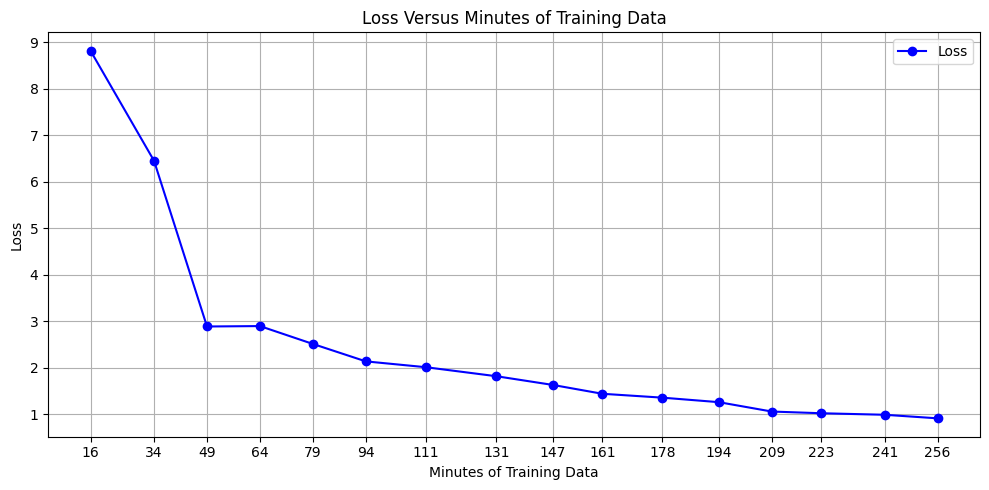

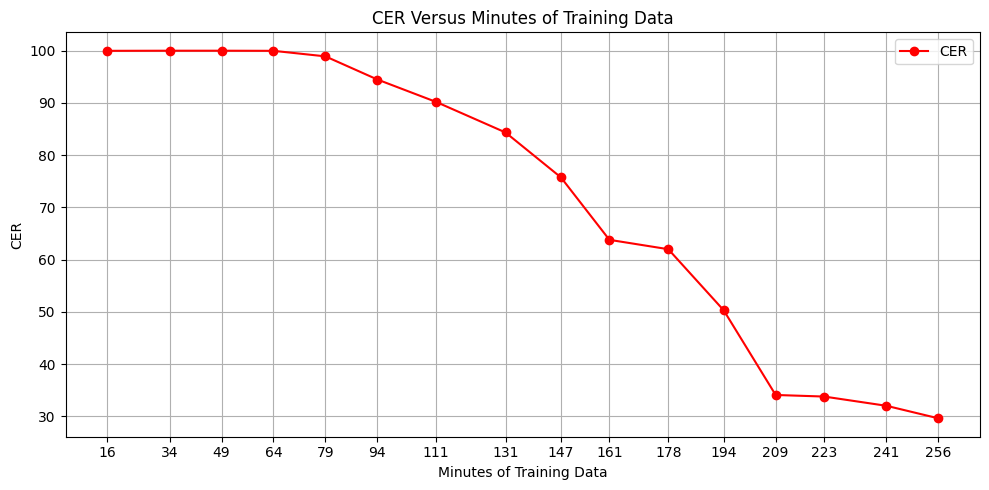

In [18]:
import matplotlib.pyplot as plt

import pandas as pd
import yaml

durationList = []
df = pd.read_csv('metadata.csv')
for i in range(1,17):

    with open(f'config/user/single_user{i}.yaml', 'r') as yaml_file:
        yaml_data = yaml.safe_load(yaml_file)

    session_ids = []
    for entry in yaml_data['dataset']['train']:
        session_ids.append(entry['session'])

    df_filtered = df[df['session'].isin(session_ids)]
    durationList.append(df_filtered['duration_mins'].sum())

durationList = [int(d) for d in durationList]

plt.figure(figsize=(10, 5))
plt.plot(durationList, loss_list, marker='o', color='b', label='Loss')
plt.title('Loss Versus Minutes of Training Data')
plt.xlabel('Minutes of Training Data')
plt.ylabel('Loss')
plt.xticks(durationList)
plt.grid(True)
plt.legend()
plt.tight_layout()

plt.savefig('loss_vs_train_data.png', format='png') 
plt.savefig('loss_vs_train_data.svg', format='svg') 

plt.show()

plt.figure(figsize=(10, 5))
plt.plot(durationList, CER_list, marker='o', color='r', label='CER')
plt.title('CER Versus Minutes of Training Data')
plt.xlabel('Minutes of Training Data')
plt.ylabel('CER')
plt.xticks(durationList)
plt.grid(True)
plt.legend()
plt.tight_layout()

plt.savefig('cer_vs_train_data.png', format='png') 
plt.savefig('cer_vs_train_data.svg', format='svg')  

plt.show()
